Zalecamy nie czytać notatników na githubie, ze względu na źle wyświetlające się wizualizacje i brak możliwości uruchamiania kodu. Polecamy otworzyć notatnik w google colab, następującym linkiem:

<a target="_blank" href="https://colab.research.google.com/github/OlimpiadaAI/szkolenia/blob/main/02_gradient_descent.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [41]:
#@title Kod do wizualizacji, nie trzeba go czytać (polecamy zwinąć komórkę)

import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## ten kod sluzy do wizualizacji funkcji, nie trzeba go czytać dla zrozumienia reszty wykładu
class FunctionTracker:
    def __init__(self, func):
        self.func = func
        self.x_values = []
        self.y_values = []
        self.f_values = []

    def add_point(self, x, y):
        self.x_values.append(x)
        self.y_values.append(y)
        self.f_values.append(self.func(x, y))

    def plot(self):
        # Generate mesh for the surface plot
        x_plot = np.linspace(-3.5, 3.5, 100)
        y_plot = np.linspace(-3.5, 3.5, 100)
        X, Y = np.meshgrid(x_plot, y_plot)
        Z = self.func(X, Y)

        # Create Plotly figure
        fig = go.Figure(data=[
            go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.8),
            go.Scatter3d(
                x=self.x_values,
                y=self.y_values,
                z=self.f_values,
                mode='lines+markers',
                marker=dict(size=4, color='red'),
                line=dict(color='red', width=2)
            )
        ])

        # Update plot layout
        fig.update_layout(
            title='Wizualizacja wędrówki',
            scene=dict(
                xaxis_title='x',
                yaxis_title='y',
                zaxis_title='f(x, y)',
                aspectmode='cube'
            ),
            autosize=False,
            width=800,
            height=600,
        )
        fig.show()

from matplotlib.colors import Normalize
from matplotlib.cm import plasma  # Using plasma for a suitable color gradient including yellow

def illustration():
    # Create a figure and a set of subplots with adjusted size
    fig, ax = plt.subplots(figsize=(14, 6))

    # Define the radius and center, red point locations
    radius = 2
    center = (2 + radius/2, 0)  # Position of "Ty"
    new_center = (center[0]+ radius+0.5, center[1] - 1)  # New center below the first
    
    red_point = (center[0] + radius + 0.5, radius + 1)  # Move right by radius+1 and up by radius+1

    # Define the grid for the background color centered on the new red_point position
    x = np.linspace(center[0] - 4, center[0] + 4, 400)
    y = np.linspace(-4, 4, 400)
    X, Y = np.meshgrid(x, y)
    
    # Calculate the normal distribution centered at the red point with increased sigma for wider spread
    sigma = radius   # Doubling sigma to extend the spread of the hue effect
    distances = np.sqrt((X - red_point[0])**2 + (Y - red_point[1])**2)
    Z = np.exp(-0.5 * (distances / sigma)**2)

    # Calculate the normal distribution centered at the red point
    sigma = radius
    distances = np.sqrt((X - red_point[0])**2 + (Y - red_point[1])**2)
    Z1 = np.exp(-0.5 * (distances / sigma)**2)

    # Calculate the normal distribution for the new center with a smaller radius
    new_radius = radius / 2
    new_sigma = new_radius
    new_distances = np.sqrt((X - new_center[0])**2 + (Y - new_center[1])**2)
    Z2 = np.exp(-0.5 * (new_distances / new_sigma)**2)/2

    # Combine the two distributions
    Z = Z1 + Z2

    # Normalize the distribution and create a color map
    norm = Normalize(vmin=0, vmax=np.max(Z))
    cmap = plasma

    # Display the background gradient centered appropriately
    ax.imshow(Z, extent=[center[0] - 4, center[0] + 4, -4, 4], origin='lower', cmap=cmap, aspect='auto')

    # Create a white dotted circle with radius
    circle = plt.Circle(center, 0.33*radius, color='white', fill=False, linestyle=':', linewidth=2)
    ax.add_artist(circle)
    
    # Plot the points
    ax.plot(center[0], center[1], 'o', color='white')
    ax.plot(red_point[0], red_point[1], 'o', color='red', zorder=5)
    ax.plot(new_center[0], new_center[1], 'o', color='blue', zorder=5)

    # Annotate the points
    ax.text(center[0], center[1] + 0.1, "Ty", ha='center', va='bottom', fontsize=9, color='white')
    ax.text(red_point[0], red_point[1] + 0.1, "źródło mocne", ha='center', va='bottom', fontsize=9, color='red')
    ax.text(new_center[0], new_center[1] + 0.1, "źródło słabe", ha='center', va='bottom', fontsize=9, color='blue')
   
    # Adding smaller chevron-style arrows that stay within the circle
    arrow_properties = dict(facecolor='white', edgecolor='none', width=0.01, head_width=0.15, head_length=0.1)
    arrow_length = 0.33 * radius  # Shorten to stay within the circle
    ax.arrow(center[0], center[1], 0, arrow_length, **arrow_properties)  # North
    ax.arrow(center[0], center[1], 0, -arrow_length, **arrow_properties)  # South
    ax.arrow(center[0], center[1], arrow_length, 0, **arrow_properties)  # East
    ax.arrow(center[0], center[1], -arrow_length, 0, **arrow_properties)  # West

    # Colorbar for background gradient
    sm = Normalize(vmin=0, vmax=np.max(Z))
    plt.colorbar(plt.cm.ScalarMappable(norm=sm, cmap=cmap), ax=ax, orientation='vertical', label='Siła promieniowania')

    # Set plot limits and aspects
    ax.set_xlim(center[0] - 4, center[0] + 9)
    ax.set_ylim(-4, 4)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    # Show the plot
    plt.show()


# **Gradient descent**

### **Opowieść o Naukowcu i Zagadce Promieniowania**

#### **Wstęp**
Jesteś naukowcem specjalizującym się w badaniach fal elektromagnetycznych. Twoim celem jest zlokalizowanie najintensywniejszego źródła promieniowania na rozległym, niezbadanym terenie.

#### **Narzędzie Badawcze**
Posiadasz specjalne urządzenie pomiarowe w kształcie okręgu o promieniu `epsilon`, które to trzymasz w dłoni --- na potrzeby tej historii możesz sobie wyobrażać, że `epsilon` to 5 cm. Urządzenie posiada 5 czujników: cztery równomiernie rozmieszczone czujniki na brzegu oraz jeden czujnik w środku. Urządzenie to pozwala Ci określić, z której strony pochodzi najmocniejsze promieniowanie. Co kilka kroków włączasz urządzenie, a ono dokonuje pomiaru i informuje Cię, który z 4 czujników na brzegu urządzenia zarejestrował największą wartość promieniowania. Piąty czujnik w środku zapala się, gdy stoisz dokładnie nad miejscem promieniowania. Ten środkowy czujnik oznacza więc swoim alarmem koniec poszukiwań.

#### **Proces**
Podczas każdego kroku, kierujesz się w stronę największego promieniowania, którą wskażą czujniki. Jak widać jest to bardzo naturalny algorytm zachłanny.


#### **Misja**
Zadaniem jest podążać za wskazówkami urządzenia, które kieruje Cię w stronę, gdzie czujnik wykrył największe promieniowanie. Dzięki temu systematycznie będziesz zbliżać się do potencjalnego źródła.

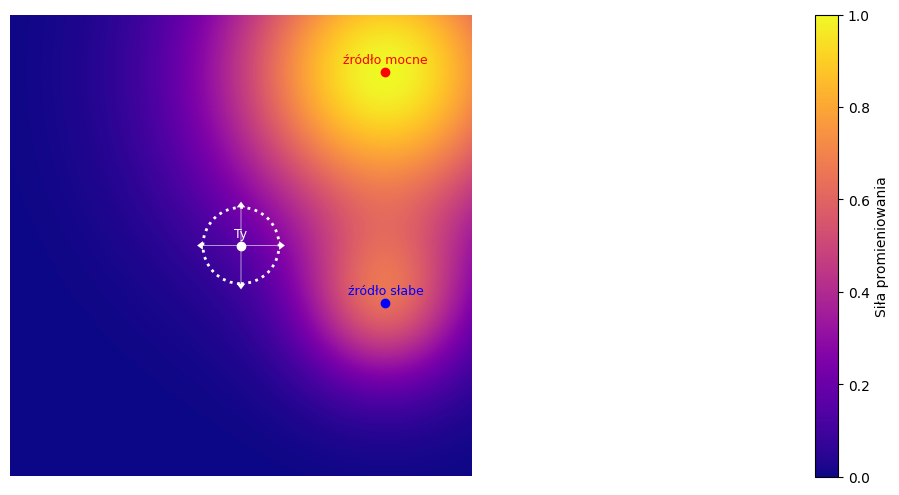

In [43]:
illustration()




#### **Wyzwanie**
Na badanym terenie znajdują się dwa źródła promieniowania. Pierwsze, bardzo silne, umiejscowione jest w punkcie $(0,0)$ i jego siła promieniowania maleje wykładniczo z kwadratem odległości, tj. $e^{-x^2-y^2}$. Drugie źródło, znajdujące się w punkcie $(1,1)$, jest słabsze, a jego siła to $\frac{1}{2}e^{-(x-1)^2-(y-1)^2}$. Mimo że jest mniej intensywne, w pewnych miejscach może wpłynąć na wyniki pomiarów pierwszego źródła.

**Uwaga**: za niedługo w notatce wykładowej o rachunku prawdopodobieństwa dowiesz się, skąd dokładnie wzięła się tutaj funkcja $e^{-x^2-y^2}$.



#### **Ostateczne Odkrycie**
Poruszając się za pomocą tej techniki, z czasem docierasz do źródła promieniowania. Urządzenie jest tak zaprojektowane, że kiedy tylko trafisz do źródła promieniowania, to zapala się środkowy 5. czujnik, który oznacza, że dalszego kroku nie można już sensownie określić.

#### **Implementacja**
Poniżej przedstawiamy kod takiego algorytmu.



### **Pobaw się kodem**

- wypróbuj różne wartości początkowe parametru `x0`:

- - zauważ, że w zależności od punktu początkowego `x0`, nie zawsze znajdowane jest źródło największego promieniowania, a taką sytuację nazywamy znalezieniem *lokalnego maksimum*;

- - zauważ, że jeśli punkt początkowy jest blisko maksimum, to bardzo szybko algorytm bardzo szybko je osiąga;

- - i na odwrót, jeśli punkt początkowy jest daleko, to być może nawet nie wystarczy ustalona z góry liczba kroków.

- wypróbuj różne wartości początkowe parametru `epsilon`:

- - zauważ, że im mniejszy `epsilon` tym gładsza trasa naukowca

- - zauważ, że jeśli z kolei `epsilon` jest zbyt duży, wtedy wędrówka może nigdy nie trafić do źródła

- wypróbuj różne wartości `num_iterations`

- - jeśli `num_iterations` jest za małe (za małe w zależności od `epsilon` i `x0`), to źródło może nie zostać osiągnięte, nawet jeśli wędrówka szła w dobrym kierunku

In [44]:


# Define the function
def f(x, y):
    return np.exp(-x**2 - y**2) + np.exp(-(x - 1)**2 - (y - 2)**2) / 2

def find_best_df(f, x):
    directions = np.array([[ 0,  1],
                           [ 0, -1],
                           [ 1,  0],
                           [-1,  0]])

    directions = directions * epsilon
    directions = directions + x 

    dir_values = np.array([f(dir[0], dir[1]) for dir in directions])
    best_dir_idx = np.argmax(dir_values)
    best_dir = directions[best_dir_idx]
    return best_dir - x

# Initialize x
x0 = np.array([1.6, 0.4])    #POBAW SIE KODEM: wyprobuj różne wartości punktu początkowego x

# Learning step parameters
num_iterations = 50         #POBAW SIE KODEM: wypróbuj różne wartości kroków iteracji
epsilon = 0.1               #POBAW SIE KODEM: wypróbuj różne wartości epislona

function_tracker = FunctionTracker(f) # ten obiekt służy jedynie do stworzenia wykresu

x = x0
# Perform gradient ascent
for i in range(num_iterations):
    df = find_best_df(f, x)
    x = x + df
    
    function_tracker.add_point(x[0], x[1])


function_tracker.plot()


#### **Podsumowanie**
Twoja podróż w poszukiwaniu źródła promieniowania stanowi ilustrację dla procesu *Gradient ascent*: metody znajdowania maksymalnych wartości funkcji poprzez iteracyjne poruszanie się w kierunku największego wzrostu funkcji. 

Kilka słów wyjaśnienia:
- w machine learningu przeważnie *minimalizujemy* funkcję, więc zwykle mówi się i spotyka się nazwę *gradient descent*;
- powyższy algorytm jest jedynie uproszczoną wersją gradient ~~descentu~~ ascentu, a opis różnic między nim a pełnym gradient ascentem znajdziesz na początku następnej sekcji; 


# **Prawdziwy Gradient Descent** (w PyTorchu)

Żeby z powyższej historyjki zrobić prawdziwy gradient descent, wystarczy zmodyfikować urządzenie. W poprzedniej wersji na okrągłym urządzeniu były 4 czujniki. Wyobraźmy sobie jednak, że kupiliśmy nowe i lepsze urządzenie, w którym są nie 4, ale 444 czujniki. Wtedy czujnik, który się zapali będzie już z bardzo dużą dokładnością wskazywał prawdziwy kierunek. Ten prawdziwy kierunek, który urządzenie stara się odczytać, to właśnie *gradient*, czyli prawdziwy kierunek największego wzrostu funkcji/promieniowania.
PyTorch jest w stanie właśnie takie prawdziwe kierunki, czyli gradienty, wyznaczyć precyzyjnie, dzięki mechanizmowi automatycznego różniczkowania, zwanego `autograd`em, z którego korzysta.



### **Gradienty**
W przypadku Pytorcha każdy kolejny krok jest wyliczany na podstawie *gradientu* $\nabla f(x)$ funkcji $f$ w punkcie $x$. Formalna definicja gradientu to


$$
\nabla f(x, y) = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right),
$$
gdzie $\frac{\partial f}{\partial x}$ to pochodna funkcji $f(x,y)$ po zmiennej $x$, a $\frac{\partial f}{\partial y}$ to *pochodna* funkcji $f(x,y)$ po zmiennej $y$. 

Jeśli ktoś z Państwa jeszcze nie uczył się obliczania pochodnych, to zupełnie nie szkodzi. Nie będziemy musieli zagłębiać się w nie bardziej niż to co pokazane w tym wykładzie. Tymczasem dla osób, które są chętne wiedzieć więcej, powstanie Appendix, w którym wytłumaczymy, nieco więcej na temat pochodnych.


### **Implementacja**
Poniżej przedstawiony jest prawie że identyczny kod jak z historyjki o naukowcu, ale zaimplementowany w PyTorchu.

Różnice w stosunku do poprzedniego algorytmu:

-- W poprzednim algorytmie funkcja `find_best_df` szukała przyrostu `dx` wybierając spośród 4 kierunków; poniżej natomiast PyTorch oblicza bardzo precyzyjnie wartość gradientu $\nabla f(x)$ a jego wartość jest zapisana w `x.grad`.  

-- `learning_rate` odpowiada długości kroku, jaki wykonujemy wzdłuż wektora największego wzrostu.


### **Pobaw się kodem**
- wypróbuj różne wartości parametru `learning_rate`
- zauważ podobieństwo między parametrem `learning_rate` z poniższego przykładu, a parametrem `epsilon` z historyjki o naukowcu.

In [45]:
import torch

# Define the function using Numpy, only for plotting
def f_np(x, y):
    return np.exp(-x**2 - y**2) + np.exp(-(x - 1)**2 - (y - 2)**2) / 2

function_tracker = FunctionTracker(f_np)


# Define the function using PyTorch
def f(x):
    return torch.exp(-x[0]**2 - x[1]**2) + torch.exp(-(x[0] - 1)**2 - (x[1] - 2)**2) / 2

# Parameters for the optimization
x0 = torch.tensor([1.6, 0.4], dtype=torch.float, requires_grad=True)  # Starting point
learning_rate = 0.1  # Step size
num_iterations = 100  # Number of steps

x = x0
# Gradient ascent
for i in range(num_iterations):
    # Compute the function value and perform backpropagation to get the gradient
    value = f(x)
    value.backward()

    # Perform a parameter update with torch.no_grad() to avoid tracking this operation
    with torch.no_grad():
        x += learning_rate * x.grad
        # Manually zero the gradients after updating the weights
        x.grad.zero_()

    function_tracker.add_point(x[0].item(), x[1].item())

function_tracker.plot()

# **PyTorch nie jest taki straszny, czyli PyTorch domowej roboty**

Zdaję sobie sprawę, że pierwszy kontakt z PyTorchem może być bardzo onieśmielający. Tym bardziej, że jeszcze nie opowiedzieliśmy, czym dokładnie jest gradient z matematycznego punktu widzenia. 

Zapewnię Cię jednak, że nie jest to wcale takie skomplikowane. Powiedziałbym nawet, że cała istota działania PyTorcha jest przedstawiona poniżej w zaledwie dwóch komórkach kodu. Poniższa funkcja `Gradient(f,x)` oblicza również gradient  $\nabla f(x)$, jednakże robi to nie tak precyzyjnie i nie tak szybko jak PyTorch. Ale jak widać, tak zmodyfikowany algorytm cały czas działa w naszym prostym przypadku historyjki o naukowcu.


Co dokładnie dzieje się w poniższej implementacji funkcji `Gradient(f,x)` nie będziemy już tutaj wchodzić. Dla chętnych powstanie Appendix, w którym to wytłumaczymy.

Uwierz mi jednak, że jeśli zrozumiał(a/e)ś wszystko z tego notatnika, to naprawdę możesz już zacząć robić piękne rzeczy za pomocą PyTorcha. A do zrozumienia pełni jego działania wystarczy zrozumienie dodatkowych $7$ linii kodu, czyli tego, co dzieje się w definicji funkcji `Gradient(f,x)`. To jednak odłóżmy już.

In [46]:
def Gradient(f,x, epsilon=0.01):
    Gf = np.zeros(len(x))
    for i in range(0, len(x)):
        e_i = np.zeros(len(x))
        e_i[i] = 1
        Gf[i] = (f(x + epsilon * e_i) - f(x))/epsilon
    return Gf

In [47]:
import torch

# Define the function using PyTorch
def f(x):
    return np.exp(-x[0]**2 - x[1]**2) + np.exp(-(x[0] - 1)**2 - (x[1] - 2)**2) / 2

# Parameters for the optimization
x0 = np.array([1.6, 0.4])  # Starting point
learning_rate = 0.1  # Step size
num_iterations = 100  # Number of steps

function_tracker = FunctionTracker(lambda x, y: f(np.array([x, y])))

df_list = []
fx_list = []

x = x0
# Gradient ascent
for i in range(num_iterations):
    x_prev = x
    # Compute the function value and perform backpropagation to get the gradient
    Gx = Gradient(f, x)
    x = x + learning_rate * Gx

    df_list.append((f(x) - f(x_prev)))
    fx_list.append(f(x))
    function_tracker.add_point(x[0], x[1])

function_tracker.plot()

### **Analiza kroków algorytmu**

Spójrzmy już tylko na koniec na wykresy wartości funkcji oraz lokalnych przyrostów funkcji w zależności od kroków algorytmu.

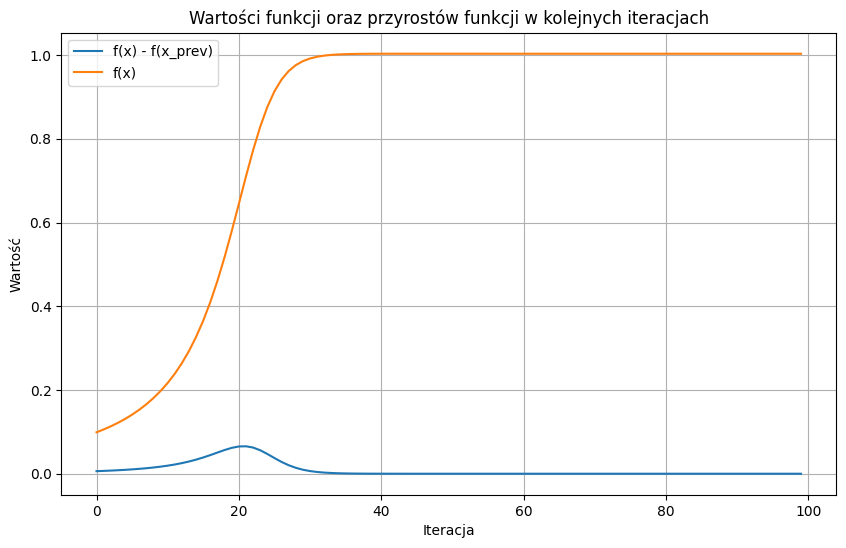

In [48]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(range(len(df_list)), df_list, label='f(x) - f(x_prev)')
plt.plot(range(len(fx_list)), fx_list, label='f(x)')

# Adding labels and title
plt.xlabel('Iteracja')
plt.ylabel('Wartość')
plt.title('Wartości funkcji oraz przyrostów funkcji w kolejnych iteracjach')

# Adding legend
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

Można z niego odczytać wiele rzeczy:
- około 30. kroku przyrosty (gradienty) zaczęły być tak bliskie zeru, że zarówno wartość funkcji przestała istotnie rosnąć 
- im szybciej funkcja rośnie (pomarańczowa linia), tym większe są przyrosty (niebieska linia)

## **Podsumowanie**
Zapamiętajmy proszę jeden z najważniejszych wniosków tego wykładu.

<br/>

**Wniosek** Gradient $\nabla f(x)$ jest w przybliżeniu równy wartości funkcji `Gradient(f,x)`.